In [ ]:
import torch
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)

if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# MNIST 데이터셋 다운로드

# root : 불러올 데이터셋 위치
# train : True(학습셋), False(테스트셋)
# transform : 불러올 이미지를 트랜스폼할 함수
# download : True이면 데이터셋을 로컬폴더로 다운로드. 이미 다운로드되면 안함

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                          train = False,
                          transform = transforms.ToTensor(),
                          download = True)

In [ ]:
# parameters
training_epochs = 15
batch_size = 100

In [ ]:
# 불러온 데이터셋을 신경망 입력에 맞게 추가로 관리
# dataset : 대상 데이터셋
# batch_size : 배치마다 몇개 샘플 로드
# shuffle : True면 매 에폭마다 데이터 셔플링
# drop_last : True면 마지막 배치가 샘플수 모자라면 버림

data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

3층 신경망 생성

In [ ]:
# MNIST data image of shape 28*28 = 784
# 각 Affine 층(입력 데이터에 선형 트랜스폼 수행) 모듈 생성

# 인자 1번:입력, 2번:출력
# bias : False면 편향 사용 X

linear1 = torch.nn.Linear(784, 50, bias = True)
linear2 = torch.nn.Linear(50, 100, bias = True)
linear3 = torch.nn.Linear(100, 10, bias = True)

# 활성화함수 모듈 생성

sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()
# relu = torch.nn.ReLU()

# 만들어진 층, 활성화함수 모듈들을 순서대로 연결해서 모델 생성
# 타겟 영상 플랫폼 설정

model = torch.nn.Sequential(linear1, sigmoid, linear2, relu, linear3).to(device)

# 에폭, 배치사이즈, 층, 활성화함수, lr 등 조절

손실함수, 옵티마이저 생성

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device) # 내부에 softmax 포함

# Stochastic gradient descent
# 1번 인자 : 최적화할 파라미터 그룹
# lr : learning rate

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

학습

In [ ]:
for epoch in range(training_epochs):

  avg_cost = 0
  total_batch = len(data_loader)

  for X, T in data_loader:
    # 이미지 1차원 변환, 입력데이터 = batch_size X 784
    # T는 레이블 인코딩되어 있음
    X = X.view(-1, 28*28).to(device)
    T = T.to(device)

    optimizer.zero_grad() # 기존 계산한 경사값 삭제
    output = model(X) # 순방향 연산
    cost = criterion(output, T) # 손실함수 설정
    cost.backward() # 경사값 계산
    optimizer.step() # 업데이트 1회 수행

    avg_cost += cost / total_batch # 평균 손실함수값 계산

  print('Epoch:', '%04d' % (epoch+1), 'cost=','{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost= 1.277919531
Epoch: 0002 cost= 0.408030182
Epoch: 0003 cost= 0.319354028
Epoch: 0004 cost= 0.275896341
Epoch: 0005 cost= 0.242576256
Epoch: 0006 cost= 0.216173828
Epoch: 0007 cost= 0.195270196
Epoch: 0008 cost= 0.178111181
Epoch: 0009 cost= 0.163540184
Epoch: 0010 cost= 0.151462719
Epoch: 0011 cost= 0.140929163
Epoch: 0012 cost= 0.132720321
Epoch: 0013 cost= 0.124595858
Epoch: 0014 cost= 0.116961479
Epoch: 0015 cost= 0.111301467
Learning finished


Accuracy: 0.9261000156402588
Label: 8
Prediction: 3


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


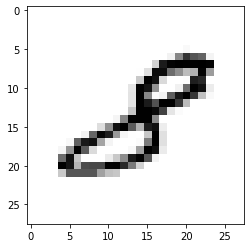

In [ ]:
with torch.no_grad():
  X_test = mnist_test.test_data.view(-1, 28*28).float().to(device)
  T_test = mnist_test.test_labels.to(device)

  # 테스트 셋에 대해 추론 수행
  output = model(X_test)

  # 출력값이 가장 높은 뉴런의 인덱스와 정답 비교, 맞으면 1 틀리면 0
  correct_prediction = torch.argmax(output,1)==T_test

  # 정확도 계산
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

  # 테스트셋 중 임의로 하나 선택
  r = random.randint(0, len(mnist_test) - 1)
  X_single_data = mnist_test.test_data[r:r+1].view(-1,28*28).float().to(device)
  T_single_data = mnist_test.test_labels[r:r+1].to(device)

  print('Label:', T_single_data.item())
  single_output = model(X_single_data)
  print('Prediction:', torch.argmax(single_output, 1).item())

  # 선택된 테스트 이미지 출력
  plt.imshow(mnist_test.test_data[r:r+1].view(28,28), cmap='Greys', interpolation='nearest')
  plt.show()

[[ 954    0    5    3    2    3    1    3    1    8]
 [   0 1098   16    1    0    1    2   13    4    0]
 [  12    2  967   21    3    3   10    8    4    2]
 [   3    3   11  937    0   23    2    8   15    8]
 [   5    0    6    6  884    6   13   12    6   44]
 [  13    1    4   25    4  803   12    7   13   10]
 [  19    1    7    6    9   11  899    0    6    0]
 [   1    4   21   10    2    0    0  969    5   16]
 [  17    8   62   22    0    7   13   10  825   10]
 [   6    4    1    5   29    9    1   16   13  925]]


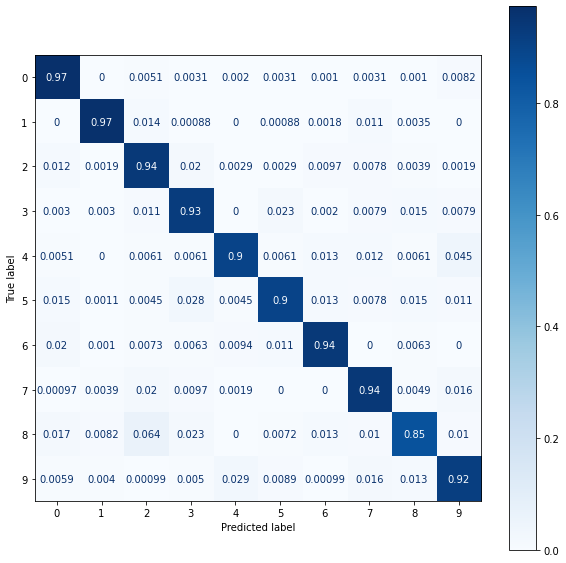

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(T_test.cpu(), torch.argmax(output,1).cpu())
print(cm)

plt.rcParams['figure.figsize'] = (10,10)
labels = [0,1,2,3,4,5,6,7,8,9]

# 노멀라이즈
cm = cm/np.repeat(np.bincount(T_test.cpu()), 10).reshape(10,10)

cm_display = ConfusionMatrixDisplay(cm, display_labels = labels).plot(cmap=plt.cm.Blues)